# Chemical concentrations at Priority Marine Features (PMFs)


## This script is for plotting time-series Tracer cocn. at selected PMF sites

### Import Libraries

In [5]:
import tfv.xarray
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import scipy.io
import numpy as np
from matplotlib.dates import DateFormatter
from scipy.io import loadmat
import matplotlib.dates as mdates
# define function to convert MATLAB datenum to pandas datetime
def convtime(matlab_datenum):
    return pd.to_datetime(matlab_datenum - 719529, unit='D')


### Open files as xarray objects

In [6]:
#neap output
ds1 = xr.open_dataset(r"X:\Scratch1\aqua_dis_3hr_neap_001.nc", decode_times=False)

#spring output
#ds2 = xr.open_dataset(r"X:\Scratch1\aqua_dis_3hr_spring_001.nc", decode_times=False)

Check what's inside

In [7]:
ds1
#ds2

<xarray.Dataset>
Dimensions:      (Time: 1225, NumCells2D: 34306, MaxNumCellVert: 4,
                  NumCells3D: 560534, NumVert2D: 19075, NumLayerFaces3D: 594840)
Dimensions without coordinates: Time, NumCells2D, MaxNumCellVert, NumCells3D,
                                NumVert2D, NumLayerFaces3D
Data variables: (12/22)
    ResTime      (Time) float64 ...
    cell_Nvert   (NumCells2D) int32 ...
    cell_node    (NumCells2D, MaxNumCellVert) int32 ...
    NL           (NumCells2D) int32 ...
    idx2         (NumCells3D) int32 ...
    idx3         (NumCells2D) int32 ...
    ...           ...
    V_x          (Time, NumCells3D) float32 ...
    V_y          (Time, NumCells3D) float32 ...
    SAL          (Time, NumCells3D) float32 ...
    TEMP         (Time, NumCells3D) float32 ...
    TRACE_1      (Time, NumCells3D) float32 ...
    TRACE_2      (Time, NumCells3D) float32 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

Add TUFLOW FV Specific flavours to netcdfs by running `.tfv`

In [8]:
ds1.tfv
#ds2.tfv


<xarray.Dataset>
Dimensions:      (Time: 1225, NumLayerFaces3D: 594840, NumCells2D: 34306,
                  NumCells3D: 560534)
Coordinates:
  * Time         (Time) datetime64[ns] 2022-10-13 ... 2022-10-30
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables:
    ResTime      (Time) float64 2.874e+05 2.874e+05 ... 2.878e+05 2.878e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    H            (Time, NumCells2D) float32 ...
    V_x          (Time, NumCells3D) float32 ...
    V_y          (Time, NumCells3D) float32 ...
    SAL          (Time, NumCells3D) float32 ...
    TEMP         (Time, NumCells3D) float32 ...
    TRACE_1      (Time, NumCells3D) float32 ...
    TRACE_2      (Time, NumCells3D) float32 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

## Get modelled Tracer timeseries data and plot

Organise sites of interest.   
Read these sites as a csv file.    
Specify the time range with start and end times.  
Get timeseries data

Depth extraction options; 
- datum='depth',limits=(0,2) - to extract depth average data at the top 2m of the water column
- datum='height',limits=(0,2) - to extract depth average data at the bottom 2m of the water column
- datum='sigma',limits=(0,1) - to extract depth average data of the whole water column


In [9]:
# read location data from csv file
loc_data = r"M:\Aqua\data\aqua_PMFs_nearby.csv"
df = pd.read_csv(loc_data, delimiter=',', usecols=['X', 'Y', 'Site'])
locs = {}
for i, row in df.iterrows():
    locs[row['Site']] = (row['X'], row['Y'])

# set time range
start_time = dt.datetime(2022, 10, 13, 0, 0, 0)  # replace with your start time
end_time = dt.datetime(2022, 10, 30, 0, 0, 0)  # replace with your end time



In [10]:

# get time-series data for different variables
ts1_top = ds1.tfv.get_timeseries(['TRACE_1'], locs, datum='depth', limits=(0, 1))
ts1_btm = ds1.tfv.get_timeseries(['TRACE_1'], locs, datum='height', limits=(0, 1))
#ts2_top = ds2.tfv.get_timeseries(['TEMP'], locs, datum='depth', limits=(0, 1))
#ts2_btm = ds2.tfv.get_timeseries(['TEMP'], locs, datum='height', limits=(0, 1))

Extracting timeseries, please wait: 100%|██████████████████████████████████████████| 1225/1225 [00:29<00:00, 41.17it/s]


Feel free to chcek BMT colours and hex codes
https://www.bmtintra.net/corporateidentity/default.aspx?#palette-modal.  
  
hex_codes = [
    "#005581",
    "#1ABDC9",
    "#D6E9E0",
    "#E20177",
    "#D4D00F",
    "#00B6DD",
    "#7ED1E1",
    "#B9E0F7",
    "#D8D0C7",
    "#8B9B93",
    "#887665",
    "#4F5650"
]

Lets create subplots for all the modlled data.  
I'm going to plot TEMP surface and bottom data here at three selected sites.

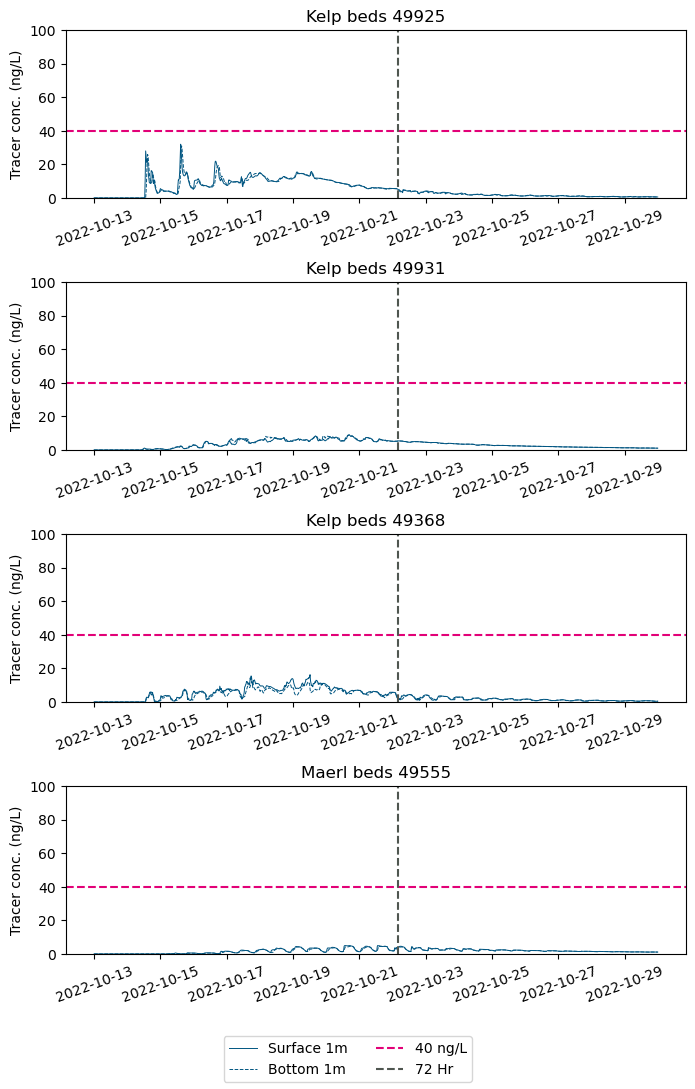

In [15]:
# loop through the site lists and create the subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))
#for i, site in enumerate(['Kelp beds 49925', 'Kelp beds 49931','farm centre']):
#['Kelp beds 49925' is the closest in the West side, Kelp beds 49931 is the closest in the East side'
#,'Kelp beds 49368' is second closest in the West side,'Maerl beds 49555'is second closest in the East,]):
for i, site in enumerate(['Kelp beds 49925', 'Kelp beds 49931','Kelp beds 49368','Maerl beds 49555']):
    # get the top and bottom data for the current site
    btmts1_data = ts1_btm.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='TEMP')
    topts1_data = ts1_top.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='TEMP')
    #btmts2_data = ts2_btm.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='TEMP')
    #topts2_data = ts2_top.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='TEMP')
           
    # create the subplot and plot the data
    axs[i].plot_date(topts1_data.Time.values, topts1_data.values[0], fmt='-', color='#005581',label='Surface 1m',linewidth=0.7)
    axs[i].plot_date(btmts1_data.Time.values, btmts1_data.values[0], fmt='--', color='#005581',label='Bottom 1m',linewidth=0.7)
    #axs[i].plot_date(topts2_data.Time.values, topts2_data.values[0], fmt='-', color='#1ABDC9',label='Surface Model_WQ009',linewidth=0.7)
    #axs[i].plot_date(btmts2_data.Time.values, btmts2_data.values[0], fmt='--', color='#1ABDC9',label='Bottom Model_WQ009',linewidth=0.7)
    
    
    # set y-axis limits and ticks, and add y-axis label
    axs[i].set_ylim([0,100])
    #axs[i].set_yticks([0,2,4,6,8,10])
    axs[i].set_ylabel('Tracer conc. (ng/L)')
    
    Neap_Final_Treatment = pd.to_datetime('2022-10-19 04:00:00', format='%Y-%m-%d %H:%M:%S')
    vline_time = Neap_Final_Treatment + pd.Timedelta(hours=72)
    # Add EQS lines
    axs[i].axhline(y=40, color='#E20177', linestyle='dashed', label='40 ng/L')
    axs[i].axvline(x=vline_time, color='#4F5650', linestyle='dashed', label='72 Hr')
    
    # set subplot title and x-axis label to date format
    axs[i].set_title(site)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i].tick_params(axis='x', rotation=20)
    
# add common legend under the last subplot
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

# adjust subplot spacing and save the figure
fig.subplots_adjust(hspace=0.5)
plt.savefig('../figures/aqua_tracer_conc.PMFs_nearby_neap.png')


